# MLWorkbench Magics

The MLWorkbench Magics are a set of Datalab magic functions that allow an easy code-free experience to training, deploying, and predicting ML models. This notebook will take the cleaned data from the previous notebook and build a text classification model. The MLWorkbench Magics are a collection of magic commands for each step in ML workflows: analyzing input data to build transforms, transforming data, training a model, evaluating a model, and deploying a model. This notebook will showcase each step locally. The 20 newsgroup data is too small to need cloud services, but the magic commands can easily be used to start cloud jobs on large datasets.

The commands in this notebook run the sample without calling ML Engine services. The next notebook in this sequence shows the cloud version of these commands and uses Google Cloud Platform.

If you changed the WORKSPACE_PATH variable in the previous notebook, you must also change it here. If you made no modifications, there is no need to update the next cell. The previous notebook must be executed before this one.

In [2]:
WORKSPACE_PATH = '/content/workspace/text_classification_20newsgroup'

In [4]:
import google.datalab.contrib.mlworkbench.commands  # This loads the '%%ml' magics
import os

In [61]:
# Make some constant file paths

# Input files
train_csv_file = os.path.join(WORKSPACE_PATH, 'news_clean_train.csv')
eval_csv_file = os.path.join(WORKSPACE_PATH, 'news_clean_test.csv')

# For analyze step
analyze_output = os.path.join(WORKSPACE_PATH, 'analyze_output')

# For the transform step
transform_output = os.path.join(WORKSPACE_PATH, 'transform_output')
transformed_train_pattern = os.path.join(transform_output, 'features_train*')
transformed_eval_pattern = os.path.join(transform_output, 'features_eval*')

# For the training step
training_output = os.path.join(WORKSPACE_PATH, 'training_output')

# For the prediction steps
batch_predict_output = os.path.join(WORKSPACE_PATH, 'batch_predict_output')
evaluation_model = os.path.join(training_output, 'evaluation_model')
regular_model = os.path.join(training_output, 'model')

# Step 1: Analyze the csv file
The first step in the MLWorkbench workflow is to analyze the data for the requested transformations. We are going to build a bag of words representation on the text and use this in a linear model. Therefore, the analyze step will compute the vocabularies and related statistics of the data for traing.

In [6]:
%%ml analyze
output: $analyze_output
training_data:
  csv: $train_csv_file
  schema:
    - name: news_label
      type: STRING
    - name: text
      type: STRING
features:
  news_label:
    transform: target
  text:
    transform: bag_of_words

Expanding any file patterns...
file list computed.
Analyzing file /content/workspace/text_classification_20newsgroup/news_clean_train.csv...
file /content/workspace/text_classification_20newsgroup/news_clean_train.csv analyzed.


In [5]:
!ls $analyze_output

features.json  schema.json  stats.json	vocab_news_label.csv  vocab_text.csv


# Step 2: Transforming the input data

This step is optional as training can start from csv data (the same data used in the analysis step). The transform step performs some transformations on the input data and saves the results to a special TensorFlow file called a TFRecord file containing TF.Example protocall buffers. This allows training to start from preprocessed data. If this step is not used, training would have to perform the same preprocessing on every row of csv data every time it is used. As TensorFlow reads the same data row multiple times during training, this means the same row would be preprocessed multiple times. By writing the preprocessed data to disk, we can improve training performance. Because the the 20 newsgroups data is small, this step does not matter, but we do it anyway for illustration. This step is recommended if there are text column in a dataset, and required if there are image columns in a dataset.

We run the transform step for the training and eval data.

In [36]:
%%ml transform --shuffle
output: $transform_output
analysis: $analyze_output
prefix: features_train
training_data:
  csv: $train_csv_file

/usr/local/lib/python2.7/dist-packages/apache_beam/coders/typecoders.py:135: UserWarning: Using fallback coder for typehint: Any.
  warnings.warn('Using fallback coder for typehint: %r.' % typehint)
2017-07-12 17:42:17.049246: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE4.1 instructions, but these are available on your machine and could speed up CPU computations.
2017-07-12 17:42:17.049274: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE4.2 instructions, but these are available on your machine and could speed up CPU computations.
2017-07-12 17:42:17.049286: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use AVX instructions, but these are available on your machine and could speed up CPU computations.
2017-07-12 17:42:17.049296: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use AVX2 i

In [37]:
%%ml transform 
output: $transform_output
analysis: $analyze_output
prefix: features_eval
training_data:
  csv: $eval_csv_file

2017-07-12 17:42:29.386358: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE4.1 instructions, but these are available on your machine and could speed up CPU computations.
2017-07-12 17:42:29.386398: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE4.2 instructions, but these are available on your machine and could speed up CPU computations.
2017-07-12 17:42:29.386421: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use AVX instructions, but these are available on your machine and could speed up CPU computations.
2017-07-12 17:42:29.386445: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use AVX2 instructions, but these are available on your machine and could speed up CPU computations.
2017-07-12 17:42:29.386467: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't

Note how more than 1 file may have been made for training and eval. Sharding an input file can improve TensorFlow training performance, especially when running on a distributed cluster. 

In [38]:
!ls $transform_output

errors_features_eval-00000-of-00001.txt
errors_features_train-00000-of-00001.txt
features_eval-00000-of-00008.tfrecord.gz
features_eval-00001-of-00008.tfrecord.gz
features_eval-00002-of-00008.tfrecord.gz
features_eval-00003-of-00008.tfrecord.gz
features_eval-00004-of-00008.tfrecord.gz
features_eval-00005-of-00008.tfrecord.gz
features_eval-00006-of-00008.tfrecord.gz
features_eval-00007-of-00008.tfrecord.gz
features_train-00000-of-00001.tfrecord.gz


An errors file is always written, even if there are no errors. Let's check the error files are empty.

In [39]:
!wc -l $transform_output/errors*

0 /content/workspace/text_classification_20newsgroup/transform_output/errors_features_eval-00000-of-00001.txt
0 /content/workspace/text_classification_20newsgroup/transform_output/errors_features_train-00000-of-00001.txt
0 total


# Step 3: Training a TensorFlow model
MLWorkbench automatically builds standard TensorFlow models without you having to write any TensorFlow code. 

In [41]:
# Training should use an empty output folder. So if you run training multiple times,
# use different folders or remove the output from the previous run.
!rm -fr $training_output

In [42]:
%%ml train
output: $training_output
analysis: $analyze_output
training_data:
  transformed: $transformed_train_pattern
evaluation_data:
  transformed: $transformed_eval_pattern
model_args:
  l2-regularization: 5
  model: linear_classification
  top-n: 4
  learning-rate: 1
  max-steps: 5000
  train-batch-size: 500
  eval-batch-size: 500
  save-checkpoints-secs: 60

INFO:tensorflow:Using config: {'_save_checkpoints_secs': 60, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_task_type': None, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f16b0001ed0>, '_model_dir': '/content/workspace/text_classification_20newsgroup/training_output/train', '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_session_config': None, '_tf_random_seed': None, '_environment': 'local', '_num_worker_replicas': 0, '_task_id': 0, '_save_summary_steps': 100, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_evaluation_master': '', '_master': ''}
Instructions for updating:
Monitors are deprecated. Please use tf.train.SessionRunHook.
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Als

The output of training is two models, one in training_output/model and another in training_output/evaluation_model. These tensorflow models are identical except the latter assumes the target column is part of the input and copies the target value to the output. Therefore, the latter is ideal for evaluation

In [43]:
!ls $training_output

evaluation_model  model  schema_without_target.json  train


# Step 4: Evaluation using batch prediction

Below, we use the evaluation model and run batch prediction locally. Batch prediction is good for large datasets where the data cannot fit in memory or when you want to limit peak memory usage.

In [62]:
%%ml batch_predict
model: $evaluation_model
output: $batch_predict_output
format: json
prediction_data:
  csv: $eval_csv_file

local prediction...
INFO:tensorflow:Restoring parameters from /content/workspace/text_classification_20newsgroup/training_output/evaluation_model/variables/variables


INFO:tensorflow:Restoring parameters from /content/workspace/text_classification_20newsgroup/training_output/evaluation_model/variables/variables


done.


In [63]:
!ls $batch_predict_output

predict_results_news_clean_test.json  predict_results_schema.json


In [64]:
!head -n 1 $batch_predict_output/predict_results_news_clean_test.json

{"score_2": 0.20030562579631805, "score_3": 0.07384685426950455, "score_4": 0.06857029348611832, "target": "rec.autos", "score": 0.35834765434265137, "predicted": "rec.autos", "predicted_2": "comp.sys.mac.hardware", "predicted_3": "rec.sport.baseball", "predicted_4": "soc.religion.christian"}


Note that the output of prediction is a dict containing the score for each label class. 'predicted_n' is the label for the nth largest score. We care about 'predicted', the final model prediction. 

In [65]:
import json

In [67]:
y_true = []
y_predicted = []
with open(os.path.join(batch_predict_output, 'predict_results_news_clean_test.json'), 'r') as f:
    for line in f:
        jline = json.loads(line)
        y_predicted.append(jline['predicted'])
        y_true.append(jline['target'])

In [68]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import itertools
classes = sorted(list(set(y_predicted + y_true)))
cm = confusion_matrix(y_true, y_predicted, classes)
print(classification_report(y_true, y_predicted, target_names=classes))

                          precision    recall  f1-score   support

             alt.atheism       0.43      0.42      0.43       319
           comp.graphics       0.57      0.64      0.60       389
 comp.os.ms-windows.misc       0.63      0.57      0.60       394
comp.sys.ibm.pc.hardware       0.63      0.56      0.59       392
   comp.sys.mac.hardware       0.66      0.60      0.63       385
          comp.windows.x       0.78      0.62      0.69       395
            misc.forsale       0.71      0.76      0.73       390
               rec.autos       0.59      0.64      0.62       396
         rec.motorcycles       0.55      0.70      0.61       398
      rec.sport.baseball       0.43      0.81      0.56       397
        rec.sport.hockey       0.88      0.81      0.85       399
               sci.crypt       0.82      0.60      0.69       396
         sci.electronics       0.47      0.52      0.49       393
                 sci.med       0.74      0.64      0.69       396
         

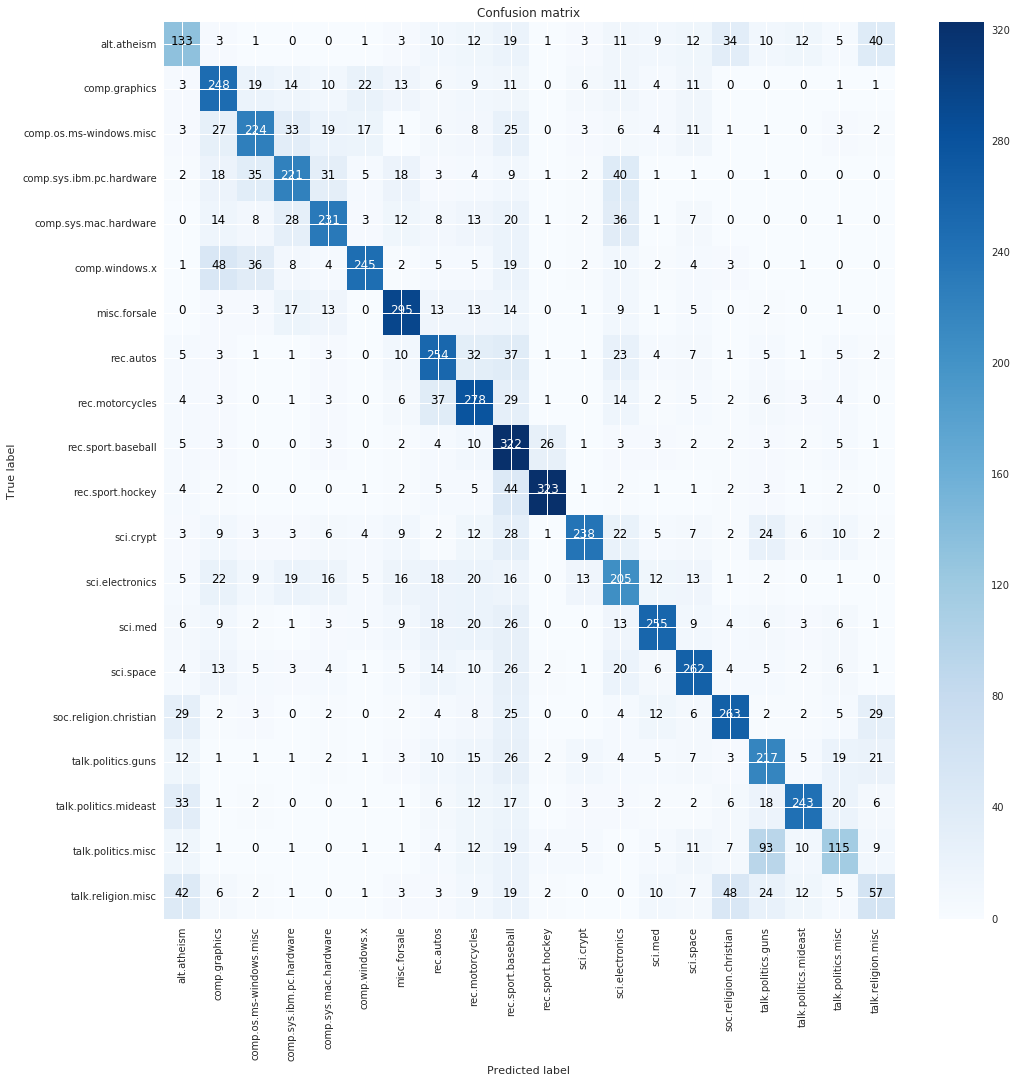

In [69]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    fig, ax = plt.subplots(figsize=(15, 15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap, aspect='auto')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
plot_confusion_matrix(cm, classes)    

As an exercise, try playing with the training parameters and see if a better model can be made.

# Step 5: Instant prediction

The MLWorkbench also supports running prediction and displaying the results within the notebook. Note that we use the non-evaluation model below, so the target column is removed.

In [72]:
%%ml predict
model: $regular_model
headers: text
prediction_data:
  - nasa
  - windows xp

INFO:tensorflow:Restoring parameters from /content/workspace/text_classification_20newsgroup/training_output/model/variables/variables


INFO:tensorflow:Restoring parameters from /content/workspace/text_classification_20newsgroup/training_output/model/variables/variables


predicted,predicted_2,predicted_3,predicted_4,score,score_2,score_3,score_4,text
sci.space,rec.motorcycles,rec.sport.baseball,rec.autos,0.129282,0.069245,0.068444,0.060461,nasa
comp.os.ms-windows.misc,comp.graphics,rec.motorcycles,rec.sport.baseball,0.210151,0.064499,0.064067,0.060785,windows xp
